In [4]:
from google.colab import drive
from os.path import join 

ROOT = "/content/gdrive/"
drive.mount(ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Exploratory Data Analysis 학습 데이터 파악

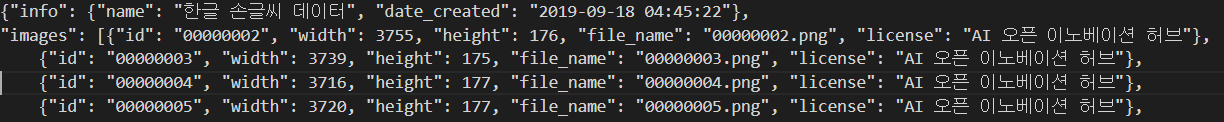

### 손글씨 데이터 파악

In [8]:
# 손글씨 데이터에서 필요한 것들 (for GAN) 
# text(클래스) : json_data['annotations'][idx]['text']
# 성별, 연령대 : json_data['annotations'][idx]['attributes']  for pretraining - 잘 쓴 손글씨(여성) => 나중에 보니까 다 여성임 -> 나눌 필요 없다.
# 이미지 크기 : json_data['images'][idx]['width'] 또는 ['height']
# 파일명 : json_data['images'][idx]['file_name']
import json

In [9]:
def getListOfHandWritingFileNames(listOfFemaleHandWritingFileNames, listOfMaleHandWritingFileNames):
    handwritingMetaFile_location = '/content/gdrive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/handwriting_data_info1.json'
    printedMetaFile_location = '/content/gdrive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/printed_data_info.json'

    with open(handwritingMetaFile_location, 'r') as f:
        hw_json_data = json.load(f)

    hw_ClassToFileNames, hw_WordsToFileNames= {}, {}
    hw_syllableDataLength = 0

    for idx, img_data in enumerate(hw_json_data['images']):
        # idx 번째 이미지 데이터들에 대해 {클래스 : [파일명, 파일명, ...]}
        class_ = hw_json_data['annotations'][idx]['text']
        fileName = hw_json_data['images'][idx]['file_name']
        if len(class_) == 1:    
            # 한 글자인 경우만 ClassToFileNames에 넣기
            if class_ not in hw_ClassToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                hw_ClassToFileNames[class_] = [] # 빈 리스트 생성
            hw_ClassToFileNames[class_].append(fileName)
            hw_syllableDataLength += 1
            if hw_json_data['annotations'][1]['attributes']['gender'] == '여':
                listOfFemaleHandWritingFileNames.append(fileName)
            else:
                listOfMaleHandWritingFileNames.append(fileName)
        else:
            # 단어, 문장의 경우 WordsToFileNames에 넣기
            if class_ not in hw_WordsToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                hw_WordsToFileNames[class_] = [] # 빈 리스트 생성
            hw_WordsToFileNames[class_].append(fileName)
    
    print("*** Handwriting Data Description ***")
    print("\t전체 데이터 수 : ", len(hw_json_data['images']) )# 여기에는 문장 데이터, 단어 데이터, 음절 데이터 모두 포함됨
    print("\t음절 클래스 수 : ", len(hw_ClassToFileNames) ) # 한국어 글자 종류는 11,172가지.
    print("\t단어/문장 클래스 수: ", len(hw_WordsToFileNames))
    print("\t음절 데이터 수 : ", hw_syllableDataLength)
    print("\t단어/문장 데이터 수 : ", len(hw_json_data['images']) - hw_syllableDataLength)
    print(f"\t한 음절 당 평균 {hw_syllableDataLength/len(hw_ClassToFileNames)} 개 손글씨 데이터 존재함")

### 인쇄체 데이터 파악

In [10]:
def getListOfPrintedFileNames(listOfPrintedFileNames):
    printedMetaFile_location = '/content/gdrive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/printed_data_info.json'

    with open(printedMetaFile_location, 'r') as f:
        p_json_data = json.load(f)

    p_ClassToFileNames, p_WordsToFileNames= {}, {}
    p_syllableDataLength = 0

    for idx, img_data in enumerate(p_json_data['images']):
        # idx 번째 이미지 데이터들에 대해 {클래스 : [파일명, 파일명, ...]}
        class_ = p_json_data['annotations'][idx]['text']
        fileName = p_json_data['images'][idx]['file_name']
        if len(class_) == 1:    
            # 한 글자인 경우만 ClassToFileNames에 넣기
            if class_ not in p_ClassToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                p_ClassToFileNames[class_] = [] # 빈 리스트 생성
            p_ClassToFileNames[class_].append(fileName)
            p_syllableDataLength += 1
            listOfPrintedFileNames.append(fileName)

        else:
            # 단어, 문장의 경우 WordsToFileNames에 넣기
            if class_ not in p_WordsToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                p_WordsToFileNames[class_] = [] # 빈 리스트 생성
            p_WordsToFileNames[class_].append(fileName)
    print("*** Printed Data Description ***")
    print("\t전체 데이터 수 : ", len(p_json_data['images']) )# 여기에는 문장 데이터, 단어 데이터, 음절 데이터 모두 포함됨
    print("\t음절 클래스 수 : ", len(p_ClassToFileNames) ) # 한국어 글자 종류는 11,172가지.
    print("\t단어/문장 클래스 수: ", len(p_WordsToFileNames))
    print("\t음절 데이터 수 : ", p_syllableDataLength)
    print("\t단어/문장 데이터 수 : ", len(p_json_data['images']) - p_syllableDataLength)
    print(f"\t한 음절 당 평균 {p_syllableDataLength/len(p_ClassToFileNames)} 개 손글씨 데이터 존재함")

    return p_ClassToFileNames

## GAN pretrain에 사용할 데이터 : 인쇄체

In [11]:
# zip 파일 읽기 
from zipfile import ZipFile
import io
from PIL import Image
import numpy as np
import torch

In [12]:
# 인쇄체 음절 이미지의 파일명  for pretrain
listOfPrintedFileNames = []
# 여성 필기체 음절 이미지의 파일명  for pretrain
listOfFemaleHandWritingFileNames = []
# 남성 필기체 음절 이미지의 파일명  for train
listOfMaleHandWritingFileNames = []

# getListOfHandWritingFileNames(listOfFemaleHandWritingFileNames, listOfMaleHandWritingFileNames)
p_ClassToFileNames = getListOfPrintedFileNames(listOfPrintedFileNames)

#print("여성 필기체 data 수 : ", len(listOfFemaleHandWritingFileNames))
#print("남성 필기체 data 수 : ", len(listOfMaleHandWritingFileNames))
print("인쇄체 data 수 : ", len(listOfPrintedFileNames))

*** Printed Data Description ***
	전체 데이터 수 :  878100
	음절 클래스 수 :  11172
	단어/문장 클래스 수:  6054
	음절 데이터 수 :  575350
	단어/문장 데이터 수 :  302750
	한 음절 당 평균 51.499283924095955 개 손글씨 데이터 존재함
인쇄체 data 수 :  575350


#### 학습 대상 클래스 수 및 데이터 수를 줄여야 함 cuda 메모리 할당 에러 떴음

In [ ]:
# p_ClassToFileNames

## 이거 아래 부분 당장은 불필요

In [ ]:
female_hw_fileName_inZIP1 = []
female_hw_fileName_inZIP2 = []

# 1_syllable/00192279.png : zip1파일 내의 데이터 중 가장 마지막 # print(zipObj.namelist()[-1]) 
# listOfFemale ... 원소 : 01200901.png
for filename in listOfFemaleHandWritingFileNames:
    if filename[:len('00192279')] < '00192279':
        female_hw_fileName_inZIP1.append('1_syllable/'+ filename)
    else:
        female_hw_fileName_inZIP2.append('2_syllable/'+ filename)

In [ ]:
# 위의 셀 모두 실행했을 떄 RAM : 1.76 GB 소모

# 음절 데이터 수 :  729251
# 위의 meta data에 따르면 761109여야 하는데 부족함. 
location1 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/01_handwriting_syllable_images.zip'
location2 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/02_handwriting_syllable_images.zip'
train_data_list = [] # 학습에 활용할 데이터

with ZipFile(location1, 'r') as zipObj: # 첫 번째 element는 empty
    for fileName in female_hw_fileName_inZIP1:
        # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족
        try:
            zipRead = zipObj.read(fileName)
            buffer = io.BytesIO(zipRead)
            encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
            train_data_list.append(encoded_img)
        except:
            pass # meta-data와 실제 data의 간극 무시

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


In [ ]:
print("손글씨 데이터의 zip1에서 얻은 pretrain용 data(여성 손글씨) 수 : ", len(pretrain_data_list))

손글씨 데이터의 zip1에서 얻은 pretrain용 data(여성 손글씨) 수 :  135839


위의 셀 모두 실행했을 떄 RAM : 2.27 GB 소모
여기서 RAM 부하 문제 발생. colab RAM 12.69GB.

In [ ]:
# 의도적 분할. RAM이 데이터 감당 못해서 cell 나눔
with ZipFile(location2, 'r') as zipObj: 
    for fileName in female_hw_fileName_inZIP2[:]: # 여기 범위 줄일 것
        try:
            zipRead = zipObj.read(fileName)
            print("ㅇ")
            buffer = io.BytesIO(zipRead)
            encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
            train_data_list.append(encoded_img)
        except:
            pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


In [ ]:
print("손글씨 데이터 전체에서 얻은 pretrain용 data(여성 손글씨) 수 : ", len(train_data_list))

In [ ]:
# 인쇄체 zip 데이터 읽기
location3 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/01_printed_syllable_images.zip'
pretrain_data_list = [] # 학습에 활용할 데이터
nonexisit_file_list = []

with ZipFile(location3, 'r') as zipObj: # 첫 번째 element는 empty
    for fileName in listOfPrintedFileNames: 
        # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족 # "There is no item named 'syllable/00532659.png' in the archive"
        # meta-data에서는 575350 개 있다고 했으나 실제는 532659 개 있음 
        try:
            zipRead = zipObj.read('syllable/'+ fileName) 
            buffer = io.BytesIO(zipRead)
            encoded_img = np.frombuffer(buffer.getvalue(), dtype = np.uint8)
            pretrain_data_list.append(encoded_img)
        except:
            nonexisit_file_list.append(fileName)
            pass 

In [ ]:
len(nonexisit_file_list)

42691

In [ ]:
p_ClassToFileNames.values() # 11172

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
nonexisit_file_list[-1]

'02511536.png'

In [ ]:
len(pretrain_data_list)
len(p_ClassToFileNames.values()) # 11172

letterClassList = []
# p_ClassToFileNames # 더 많음
for filename in pretrain_data_list:
    for idx, sameClassFileNameList in enumerate(p_ClassToFileNames.values()):
        if filename in sameClassFileNameList:
            letterClassList.append(idx) # 같은 클래스 끼리 같은 idx 가짐 [0, 123, 28784, ... ] 각 숫자는 클래스 의미
print(len(pretrain_data_list))
print(len(letterClassList))
nonexisit_file_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


## Pretrain_DataLoader

In [7]:
!pip install scipy==1.2.0

     |████████████████████████████████| 26.6 MB 75 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.2.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [13]:
import imageio
import scipy.misc as misc
import numpy as np
from io import BytesIO
from PIL import Image
from scipy.misc import imresize

import cv2

import matplotlib.pyplot as plt

In [14]:
def tight_crop_image(img, verbose=False, resize_fix=False):
    row_img_size = img.shape[0]
    col_img_size = img.shape[1]
    col_sum = np.where(col_img_size - np.sum(img, axis=0) > 1)
    row_sum = np.where(row_img_size - np.sum(img, axis=1) > 1)
    y1, y2 = row_sum[0][0], row_sum[0][-1]
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    cropped_image = img[y1:y2, x1:x2]
    cropped_image_size = cropped_image.shape
    
    if verbose:
        print('(left x1, top y1):', (x1, y1))
        print('(right x2, bottom y2):', (x2, y2))
        print('cropped_image size:', cropped_image_size)
        
    if type(resize_fix) == int:
        origin_h, origin_w = cropped_image.shape
        if origin_h > origin_w:
            resize_w = int(origin_w * (resize_fix / origin_h))
            resize_h = resize_fix
        else:
            resize_h = int(origin_h * (resize_fix / origin_w))
            resize_w = resize_fix
        if verbose:
            print('resize_h:', resize_h)
            print('resize_w:', resize_w, \
                  '[origin_w %d / origin_h %d * target_h %d]' % (origin_w, origin_h, target_h))
        
        # resize
        cropped_image = imresize(cropped_image, (resize_h, resize_w))
        cropped_image = normalize_image(cropped_image)
        cropped_image_size = cropped_image.shape
        if verbose:
            print('resized_image size:', cropped_image_size)
        
    elif type(resize_fix) == float:
        origin_h, origin_w = cropped_image.shape
        resize_h, resize_w = int(origin_h * resize_fix), int(origin_w * resize_fix)
        if resize_h > 120:
            resize_h = 120
            resize_w = int(resize_w * 120 / resize_h)
        if resize_w > 120:
            resize_w = 120
            resize_h = int(resize_h * 120 / resize_w)
        if verbose:
            print('resize_h:', resize_h)
            print('resize_w:', resize_w)
        
        # resize
        cropped_image = imresize(cropped_image, (resize_h, resize_w))
        cropped_image = normalize_image(cropped_image)
        cropped_image_size = cropped_image.shape
        if verbose:
            print('resized_image size:', cropped_image_size)
    
    return cropped_image

In [15]:
def add_padding(img, image_size=128, verbose=False, pad_value=None):
    height, width = img.shape
    if not pad_value:
        pad_value = img[0][0]
    if verbose:
        print('original cropped image size:', img.shape)
    
    # Adding padding of x axis - left, right
    pad_x_width = (image_size - width) // 2
    pad_x = np.full((height, pad_x_width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_x, img), axis=1)
    img = np.concatenate((img, pad_x), axis=1)
    
    width = img.shape[1]

    # Adding padding of y axis - top, bottom
    pad_y_height = (image_size - height) // 2
    pad_y = np.full((pad_y_height, width), pad_value, dtype=np.float32)
    img = np.concatenate((pad_y, img), axis=0)
    img = np.concatenate((img, pad_y), axis=0)
    
    # Match to original image size
    width = img.shape[1]
    if img.shape[0] % 2:
        pad = np.full((1, width), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=0)
    height = img.shape[0]
    if img.shape[1] % 2:
        pad = np.full((height, 1), pad_value, dtype=np.float32)
        img = np.concatenate((pad, img), axis=1)

    if verbose:
        print('final image size:', img.shape)
    
    return img

In [16]:
def centering_image(img, image_size=128, verbose=False, resize_fix=False, pad_value=None):
    if not pad_value:
        pad_value = img[0][0]
    cropped_image = tight_crop_image(img, verbose=verbose, resize_fix=resize_fix)
    height, width = cropped_image.shape
    if height > image_size: # dsize=(640, 480)
        cropped_image = cv2.resize(cropped_image, dsize=(width, 128))
    height, width = cropped_image.shape
    if width > image_size:
        cropped_image = cv2.resize(cropped_image, dsize=(128, height))
    centered_image = add_padding(cropped_image, image_size=image_size, verbose=verbose, pad_value=pad_value)
    
    return centered_image

In [33]:
# location = '/content/gdrive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/01_printed_syllable_images.zip'
# pretrain_data_list = [] # 학습에 활용할 데이터

# with ZipFile(location, 'r') as zipObj: # 첫 번째 element는 empty
#     for fileName in listOfPrintedFileNames[:5]: 
#         # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족 # "There is no item named 'syllable/00532659.png' in the archive"
#         # # meta-data에서는 575350 개 있다고 했으나 실제는 532659 개 있음 
#         try:
#             zipRead = zipObj.read('syllable/'+ fileName) 
#             buffer = io.BytesIO(zipRead)
#             encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
#             pretrain_data_list.append(encoded_img)
#         except:
#             pass 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


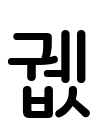

In [48]:
img = cv2.imdecode(pretrain_data_list[0], cv2.IMREAD_GRAYSCALE)
pil_image=Image.fromarray(tight_crop_image(img))
pil_image

In [59]:
print(np.shape(img)) # 124, 98
print(np.shape(tight_crop_image(img))) # 123, 97
print(np.shape(centering_image(img))) # 128, 128

(124, 98)
(123, 97)
(128, 128)


In [40]:
centering_image(img)

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [17]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim, from_numpy
import cv2

# listOfPrintedFileNames 

# pretrain용 인쇄체 dataloader 구현
class SyllablePrintedDataset(Dataset):
    def __init__(self):
        location = '/content/gdrive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/01_printed_syllable_images.zip'
        pretrain_data_list = [] # 학습에 활용할 데이터

        with ZipFile(location, 'r') as zipObj: # 첫 번째 element는 empty
            for fileName in listOfPrintedFileNames[:150000]: 
                # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족 # "There is no item named 'syllable/00532659.png' in the archive"
                # # meta-data에서는 575350 개 있다고 했으나 실제는 532659 개 있음 
                try:
                    zipRead = zipObj.read('syllable/'+ fileName) 
                    buffer = io.BytesIO(zipRead)
                    encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
                    pretrain_data_list.append(encoded_img)
                except:
                    pass 
        self.dataset = pretrain_data_list

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        data = cv2.imdecode(self.dataset[index], cv2.IMREAD_GRAYSCALE)
        processedImg = centering_image(data)
        return torch.cuda.FloatTensor(processedImg) / 255.0
    
    def get_image(self, index):
        img = cv2.imdecode(self.dataset[index], cv2.IMREAD_GRAYSCALE)
        pil_image=Image.fromarray(img)
        return pil_image

## infoGAN Model

In [18]:
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = True if torch.cuda.is_available() else False

In [19]:
class Opt:
    def __init__(self, epoch=100, batch_size=128, lr=0.0002, b1=0.5, b2=0.999, n_cpu=4, latent_dim=62, code_dim=3, n_classes=11172, img_size=128, channels=1, sample_interval=200):
        self.n_epochs = epoch              # number of epochs of training
        self.batch_size = batch_size    # size of the batches
        self.lr = lr                    # adam: learning rate
        self.b1 = b1                    # adam: decay of first order momentum of gradient
        self.b2 = b2                    # adam: decay of first order momentum of gradient
        self.n_cpu = n_cpu              # number of cpu threads to use during batch generation
        self.latent_dim = latent_dim    # dimensionality of the latent space
        self.code_dim = code_dim        # latent code
        self.n_classes = n_classes      # number of classes for dataset # 이거 너무 커서 RAM 다 써버림 11172 
        self.img_size = img_size        # size of each image dimension
        self.channels = channels        # number of image channels
        self.sample_interval = sample_interval # interval between image sampling
opt = Opt() 

In [20]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def to_categorical(y, num_columns):
    """Returns one-hot encoded Variable"""
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y] = 1.0

    return Variable(FloatTensor(y_cat))

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = opt.latent_dim + opt.n_classes + opt.code_dim

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels, code):
        gen_input = torch.cat((noise, labels, code), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())
        self.latent_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.code_dim))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        latent_code = self.latent_layer(out)

        return validity, label, latent_code

In [27]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()
categorical_loss = torch.nn.CrossEntropyLoss()
continuous_loss = torch.nn.MSELoss()

# Loss weights
lambda_cat = 1
lambda_con = 0.1

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    # adversarial_loss.cuda()
    # categorical_loss.cuda()
    # continuous_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

dataset = SyllablePrintedDataset()
dataloader = DataLoader(dataset = dataset,
                          batch_size = 128,
                          shuffle = True) 

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_info = torch.optim.Adam(
    itertools.chain(generator.parameters(), discriminator.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# # Static generator inputs for sampling
# static_z = Variable(FloatTensor(np.zeros((opt.n_classes ** 2, opt.latent_dim))))
# static_label = to_categorical(
#     np.array([num for _ in range(opt.n_classes) for num in range(opt.n_classes)]), num_columns=opt.n_classes
# )
# static_code = Variable(FloatTensor(np.zeros((opt.n_classes ** 2, opt.code_dim))))

RuntimeError: ignored

In [ ]:
g_lossL = []
d_lossL = []
info_lossL = []
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        # labels = to_categorical(labels.numpy(), num_columns=opt.n_classes)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        label_input = to_categorical(np.random.randint(0, opt.n_classes, batch_size), num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (batch_size, opt.code_dim))))

        # Generate a batch of images
        gen_imgs = generator(z, label_input, code_input)

        # Loss measures generator's ability to fool the discriminator
        validity, _, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_lossL.append(g_loss)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, _, _ = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        # Loss for fake images
        fake_pred, _, _ = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_lossL.append(d_loss)

        d_loss.backward()
        optimizer_D.step()

        # ------------------
        # Information Loss
        # ------------------

        optimizer_info.zero_grad()

        # Sample labels
        sampled_labels = np.random.randint(0, opt.n_classes, batch_size)

        # Ground truth labels
        gt_labels = Variable(LongTensor(sampled_labels), requires_grad=False)

        # Sample noise, labels and code as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        label_input = to_categorical(sampled_labels, num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (batch_size, opt.code_dim))))

        gen_imgs = generator(z, label_input, code_input)
        _, pred_label, pred_code = discriminator(gen_imgs)

        info_loss = lambda_cat * categorical_loss(pred_label, gt_labels) + lambda_con * continuous_loss(
            pred_code, code_input
        )

        info_lossL.append(info_loss)

        info_loss.backward()
        optimizer_info.step()

        # --------------
        # Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [info loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item(), info_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

In [ ]:
# 학습된 모델 저장 
generator_out_path = '/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/generator.pth'
torch.save(generator.state_dict(), generator_out_path)

discriminator_out_path = '/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/discriminator.pth'
torch.save(discriminator.state_dict(), discriminator_out_path)

In [ ]:
g_lossL = []
d_lossL = []
info_lossL = []

import csv # csv파일로 적기 # newline 설정을 안하면 한줄마다 공백있는 줄이 생긴다. 
with open('/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/lossFile.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(g_lossL) 
    writer.writerow(d_lossL) 
    writer.writerow(info_lossL)

### github 커밋

In [1]:
MY_GOOGLE_DRIVE_PATH = "/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital


In [2]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper
!git pull

Already up to date.


In [3]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   GAN/GAN.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [5]:
!git add -A

In [6]:
!git commit -m"[ADD] SaveModel&&LossTracking"

[main 578c045] [ADD] SaveModel&&LossTracking
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite GAN/GAN.ipynb (96%)


In [7]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 8.15 KiB | 1.02 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital.git
   69490d6..578c045  main -> main
